# Analiza eksploracyjna danych sezonu 2015/16 La Liga

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pymongo import MongoClient
from IPython.display import display
from mplsoccer import Pitch
import utils


In [4]:
MONGO_URI = "mongodb://localhost:27017/"
DB_NAME = "football_data"
MATCHES_COLLECTION = "matches"
EVENTS_COLLECTION = "events"

client = MongoClient(MONGO_URI)
db = client[DB_NAME]

## Dane
Przedmiotem analizy są dane sezonu 2015/16 LaLiga udostępnione za darmo przez firmę StatsBomb, jednego z największych dostawców zaawansowanych danych piłkarskich. Zostały one pobrane w formacie JSON z publicznego API dostępnego w Python za pośrednictwem biblioteki `statsbombpy`, następnie zapisane w lokalnej bazie danych MongoDB. Skrypt pobierający dane lokalnie dane znajduje się w pliku `statsbombtomongo.py`. 
W procesie analizy dane będą wczytywane do ramek danych Pandas (*Pandas Dataframes*).

In [5]:
matches = pd.DataFrame(list(db.matches.find()))

events = pd.DataFrame(list(db.events.find().limit(100000)))

lineups = pd.DataFrame(list(db.lineups.find()))

In [1]:
print("==========Mecze==========")
print(matches.shape)
print(matches.info())
print(matches.describe)
display(matches.isnull().sum())


print("==========Zdarzenia==========")
print(events.shape)
print(events.info())
print(events.describe())
display(events.isnull().sum())

print("==========Składy==========")
print(lineups.shape)
print(lineups.info())
print(lineups.describe())
display(lineups.isnull().sum())

==========Mecze==========


NameError: name 'matches' is not defined

Dane dzielą się na trzy kolekcje: mecze, zdarzenia i składy

Kolekcja meczów:
- Zawiera 380 dokumentów, po jednym na każdy mecz, z których każdy posiada 23 pola.
- Występuje 19 pól tekstowych, głównie z informacjami o lokalizacji, uczestnikach meczu i czasie w jakim się odbywał. Poza tym 4 pola liczbowe określają wynik, numer kolejki rozgrywek i unikalny identyfikator meczu.
- Brakujące dane występują w polu *last_updated_360*, które jest nieistotne i określa datę aktualizacji danych, oraz w polu *referee* które zawiera nazwisko sędziego na dany mecz i nie będzie obiektem analiz.

Kolekcja zdarzeń:
- Zawiera 1 295 354 dokumentów, ale w celach demonstracyjnych zostało wczytane pierwsze 100 000. 
- Każdy z nich ma 111 pól, w których można znaleźć bardzo szczegółowe informacje odnośnie przebiegu meczu. Większość z nich to pola tekstowe, takie jak nadawca i adresat podania, drużyna, oznaczenia czasowe, kartki. Najważniejsze z nich jest pole *type*, zawierające rodzaj zagrania (podanie, drybling, strzał, faul...)
- Brakujących danych jest bardzo wiele, gdyż większość z nich zawiera informacje istotne tylko dla konkretnego rodzaju zdarzenia, tak jak wynik strzału wyłącznie przy strzale lub adresat podania w przypadku podania.

Kolekcja składów:
- 

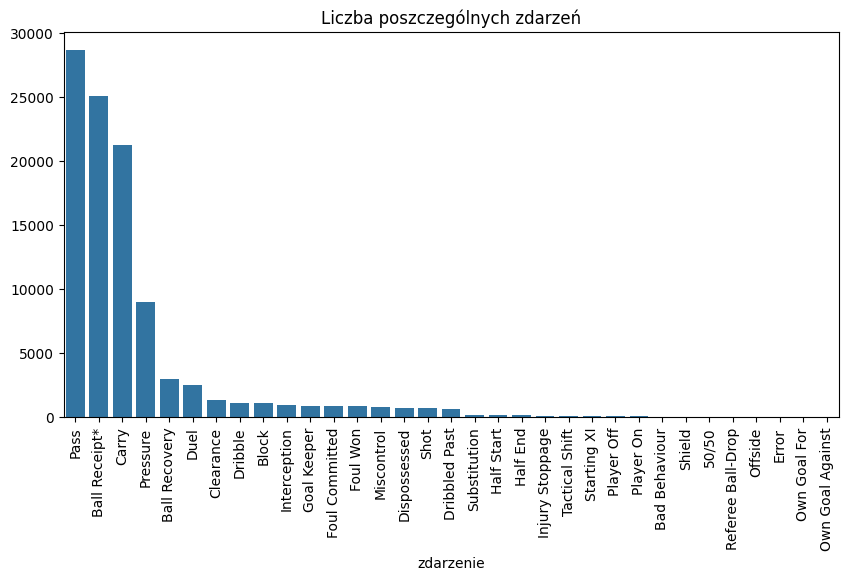

In [9]:
if 'type' in events.columns:
    event_counts = events['type'].value_counts()
    plt.figure(figsize=(10, 5))
    sns.barplot(x=event_counts.index, y=event_counts.values)
    plt.title('Liczba poszczególnych zdarzeń')
    plt.xlabel('zdarzenie')
    plt.xticks(rotation=90)
    plt.show()

## Wyniki sezonu

In [10]:
#Zliczanie goli
home_goals_scored = matches.groupby('home_team')['home_score'].sum().rename('home_goals')
away_goals_scored = matches.groupby('away_team')['away_score'].sum().rename('away_goals')
home_goals_conceded = matches.groupby('home_team')['away_score'].sum().rename('home_goals_conceded')
away_goals_conceded = matches.groupby('away_team')['home_score'].sum().rename('away_goals_conceded')

goal_stats = pd.concat([
    home_goals_scored,
    away_goals_scored,
    home_goals_conceded,
    away_goals_conceded
], axis=1)

goal_stats['goals_scored'] = goal_stats['home_goals'] + goal_stats['away_goals']
goal_stats['goals_conceded'] = goal_stats['home_goals_conceded'] + goal_stats['away_goals_conceded']
goal_stats['goal_difference'] = goal_stats['goals_scored'] - goal_stats['goals_conceded']

#pomocnicze tabele do liczenia punktów
home = matches[['home_team', 'home_score', 'away_score']].copy()
home.columns = ['team', 'goals_for', 'goals_against']
home['venue'] = 'home'

away = matches[['away_team', 'away_score', 'home_score']].copy()
away.columns = ['team', 'goals_for', 'goals_against']
away['venue'] = 'away'

results = pd.concat([home, away], ignore_index=True)

results['win'] = results['goals_for'] > results['goals_against']
results['draw'] = results['goals_for'] == results['goals_against']
results['loss'] = results['goals_for'] < results['goals_against']
results['points'] = results['win'] * 3 + results['draw'] * 1

#Łączenie tabel
league_stats = results.groupby('team').agg(
    matches_played=('team', 'count'),
    wins=('win', 'sum'),
    draws=('draw', 'sum'),
    losses=('loss', 'sum'),
    points=('points', 'sum')
)

final_table = league_stats.join(goal_stats)
final_table = final_table.sort_values(by=['points', 'goal_difference', 'goals_scored'], ascending=False)
final_table.drop('matches_played', axis=1)
col_order = ['points','goal_difference','wins','draws','losses','goals_scored','goals_conceded','home_goals','away_goals','home_goals_conceded','away_goals_conceded']
final_table = final_table[col_order]
final_table = final_table.reset_index()
final_table.index += 1
col_pl = ['Drużyna', 'Punkty','Bilans bramkowy', 'Wygrane', 'Remisy', 'Porażki', 'G. zdobyte', 'G. stracone', 'G. domowe', 'G. wyjazdowe', 'G. stracone domowe', 'G. stracone wyjazdowe']
final_table.columns = col_pl

display(final_table)


,Drużyna,Punkty,Bilans bramkowy,Wygrane,Remisy,Porażki,G. zdobyte,G. stracone,G. domowe,G. wyjazdowe,G. stracone domowe,G. stracone wyjazdowe
1,Barcelona,91,83,29,4,5,112,29,67,45,14,15
2,Real Madrid,90,76,28,6,4,110,34,70,40,16,18
3,Atlético Madrid,88,45,28,4,6,63,18,33,30,7,11
4,Villarreal,64,9,18,10,10,44,35,26,18,12,23
5,Athletic Club,62,13,18,8,12,58,45,35,23,17,28
6,Celta Vigo,60,-8,17,9,12,51,59,29,22,25,34
7,Sevilla,52,1,14,10,14,51,50,38,13,21,29
8,Málaga,48,3,12,12,14,38,35,26,12,15,20
9,Real Sociedad,48,-3,13,9,16,45,48,22,23,20,28
10,Real Betis,45,-18,11,12,15,34,52,17,17,23,29


Powyższa tabela przedstawia ostateczny kształt tabeli po rozegraniu wszystkich meczów. Każda z drużyn rozegrała ich po 38. Zwycięzcą została Barcelona zdobywszy 91 punktów. Dalej z jednym punktem straty Real Madryt i z kolejnymi dwoma punktami straty Atletico Madryt. 
Można zauważyć wielką przepaść między trzema najbardziej rozpoznawalnymi i najbogatszymi klubami a całą resztą. Czwarty Villareal zebrał jedynie 64 punkty, czyli aż 24 mniej od Atletico. Druga największa różnica w dorobku punktowym między dwoma miejscami w tabeli wynosi już tylko 8 punktów między 6 a 7 miejscem.
Zdecydowanie najsłabszym klubem było Levante z 32 punktami. Ponadto w strefie spadkowej znalazły się Rayo Vallecano i Getafe.

Największą liczbą strzelonych goli (112) i najlepszym bilansem bramkowym (+83) może się pochwalić Barcelona, następnie Real Madryt z dwoma bramkami mniej, ale zwiększą liczbą straconych, a na trzecim miejscu ponownie Atletico. Ten ostatni charakteryzuje najniższa liczba straconych goli(18), co wskazuje na bardziej defensywny styl gry. Ponownie można dostrzec dużą różnicę między trójką liderów a całą resztą.

Najgorszy bilans bramkowy (-34) ma Espanyol, który uplasował się na bezpiecznym 14-tym miescu, 5 punktów nad strefą spadkową. Można wywnioskować, że klub ten wygrywał nisko i przegrywał wysoko.

Warto zwrócić uwagę na klub RC Deportivo La Coruña, który odniósł niebywale wysoką liczbę remisów, aż 18, czyli prawie połowę swoich meczów zremisował.


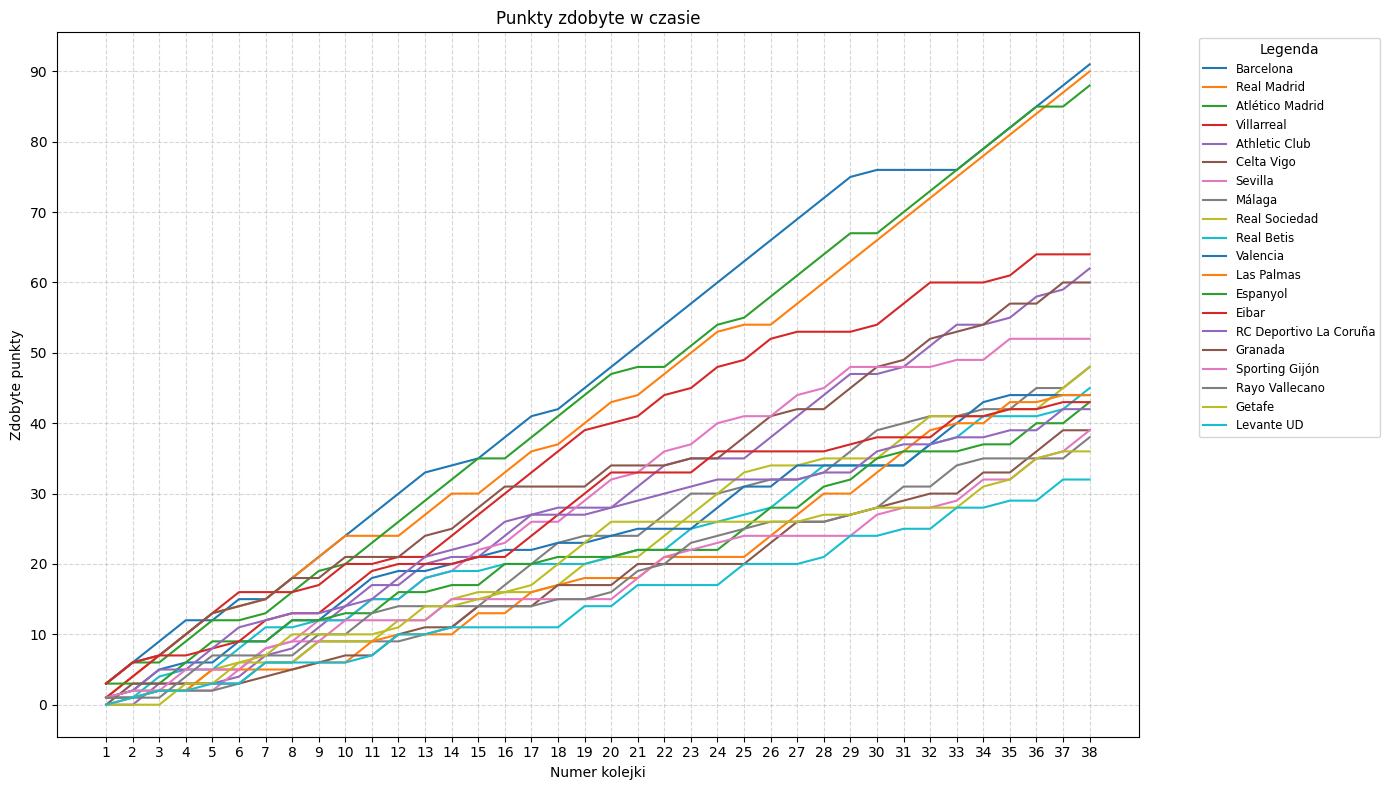

In [11]:
# Tworzenie tabeli z wynikami meczów każdej drużyny (u siebie i na wyjeździe)
home = matches[['match_id', 'match_week', 'home_team', 'home_score', 'away_score']].copy()
home['team'] = home['home_team']
home['goals_for'] = home['home_score']
home['goals_against'] = home['away_score']

away = matches[['match_id', 'match_week', 'away_team', 'away_score', 'home_score']].copy()
away['team'] = away['away_team']
away['goals_for'] = away['away_score']
away['goals_against'] = away['home_score']

results = pd.concat([home, away], ignore_index=True)

results['points'] = results.apply(
    lambda row: 3 if row['goals_for'] > row['goals_against'] else 1 if row['goals_for'] == row['goals_against'] else 0,
    axis=1
) #przypisanie punktów za każdy mecz

weekly_points = results.sort_values(by=['team', 'match_week'])

# Całkowite zdobyte punkty po danej kolejce
weekly_points['cumulative_points'] = weekly_points.groupby('team')['points'].cumsum()

# Ostateczna tabela (do legendy)
final_points = weekly_points[weekly_points['match_week'] == weekly_points['match_week'].max()]
ordered_teams = final_points.sort_values(by='cumulative_points', ascending=False)['team']


plt.figure(figsize=(14, 8))
for team in ordered_teams:
    team_data = weekly_points[weekly_points['team'] == team]
    plt.plot(team_data['match_week'], team_data['cumulative_points'], label=team)

plt.title("Punkty zdobyte w czasie")
plt.xlabel("Numer kolejki")
plt.ylabel("Zdobyte punkty")
plt.xticks(range(1, 39))
plt.yticks(range(0,100,10))
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Legenda', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()


Na przestrzeni sezonu każda para drużyn zmierzyła się 2 razy, po jednym na każdym z ich stadionów. Sezon z reguły jest rozgrywany na przestrzeni 38 tygodni, tzw. kolejek, w których każda drużyna rozgrywa jeden mecz. Ostatnie 3 drużyny w tabeli spadają z ligi na niższy poziom rozgrywkowy, a w ich miesce od kolejnego sezonu awansują 3 nowe. Powyższy wykres ilustruje dorobek punktowy klubów na przestrzeni tych 38 kolejek. Każde zwycięstwo daje drużynie 3 punkty, remis 1 punkt, a porażka 0.

Trójka liderów już w 12-stym tygodniu zajmowała 3 pierwsze miejsca, których już nie opuściła. W jeszcze namacalny sposób jest widoczna ich przewaga nad resztą stawki.

Między 7 a 30 tygodniem Barcelona zaliczyła niesamowitą serię 23 meczów bez porażki oebjmując pierwsze miejsce z dużym zapasem punktów. Niestety między 29 a 33 tygodniem nastąpiła seria 4 meczów bez wygranej, która na tym etapie sezonu mogła ich kosztować mistrzostwo. W tym czasie zdążyło się z nimi zrównać Atletico Madryt, które w po 32 kolejce miało tyle samo punktów. Od tego momentu Barcelona wygrała już wszystkie pozostałe mecze, a Atletico w przedostatniej kolejce przegrało z najgorszą drużyną w lidze - Levante. Real Madryt od 25 kolejki odnosił same zwycięstwa i od 32 kolejki konsekwentnie utrzymywał 3 miejsce, 1 punkt za dwójką liderów o równej liczbie punktów. Kompromitacja Atletico w końcówce pozwoiła im objąć drugą lokatę w tabeli. 
Gdyby Atletico skończyło sezon zrównane punktami z Barceloną, o zwycięzcy ligi decydowałby bilans meczów bezpośrednich, w którym to górowała Barcelona po dwóch zwycięstwach 2-1 nad Atletico.

Ostateczny przegrany - Levante, od 15 kolejki do samego końca utrzymywał się na ostatnim miejscu.
W końcówce można zaobserwować zaciekłą walkę o utrzymanie w lidze między pięcioma potencjalnymi kandydatami do spadku z ligi. Żaden z nich, poza Levante, do ostatniej kolejki nie był pewny swojej pozycji. Zadecydował ostatni mecz sezonu, przegrany przez Getafe i wygrany przez Sporting Gijon.

## Analiza goli

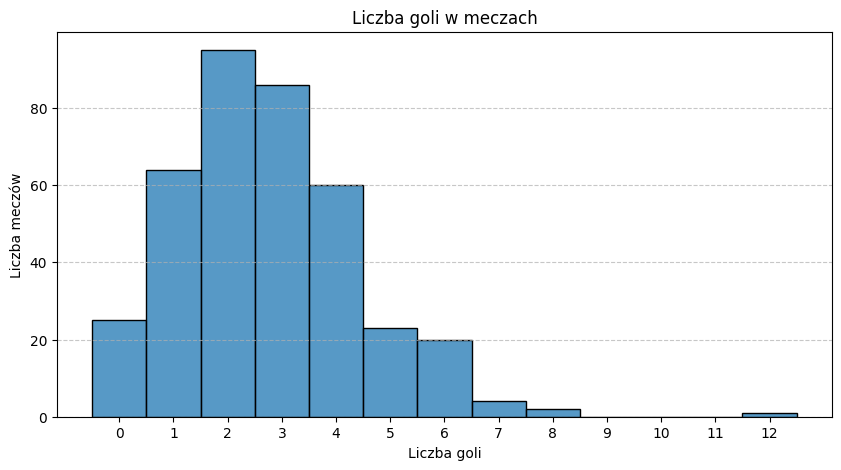

Całkowita liczba goli: 1043 
Średnia liczba goli na mecz: 2.74
Najwięcej goli padło w meczu: Real Madrid vs Rayo Vallecano (10 - 2)


In [12]:
matches['total_goals'] = matches['home_score'] + matches['away_score']


plt.figure(figsize=(10, 5))
sns.histplot(matches['total_goals'], bins=range(0, matches['total_goals'].max()+2), discrete=True)
plt.title('Liczba goli w meczach')
plt.xlabel('Liczba goli')
plt.ylabel('Liczba meczów')
plt.xticks(range(0, matches['total_goals'].max()+1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

avg_goals = matches['total_goals'].mean()
print(f"Całkowita liczba goli: {matches['total_goals'].sum()} \nŚrednia liczba goli na mecz: {avg_goals:.2f}")


# Najwięcej goli
max_goals_match = matches.loc[matches['total_goals'].idxmax()]
team1 = max_goals_match['home_team']
team2 = max_goals_match['away_team']
score = f"{max_goals_match['home_score']} - {max_goals_match['away_score']}"

print(f"Najwięcej goli padło w meczu: {team1} vs {team2} ({score})")

Wykres słupkowy prezentuje rozkład całkowitej liczby goli padających w jednym meczu. Łącznie wszystkich było ich 1043, co daje średnio 2,74 na mecz, a najczęściej w jednym meczu można było oglądać 2 gole.
Na wykresie od reszty wyraźnie odstaje 1 niski słupek przy wartości 12 goli, obrazujący zawrotne zwycięstwo 10-2 Realu Madryt nad Rayo Vallecano.

In [13]:
# Wyszukaniwanie w bazie danych wszystkich goli
normal_goals_query = {
    "type": "Shot",
    "shot_outcome": "Goal"
}
normal_goals = pd.DataFrame(list(db.events.find(normal_goals_query)))

# Dołączenie goli samobójczych, nie są one traktowane jak strzały
own_goals_query = {
    "type": "Own Goal For"
}
own_goals = pd.DataFrame(list(db.events.find(own_goals_query)))

goals = pd.concat([normal_goals, own_goals], ignore_index=True)

print(goals.shape) #powinno być 1043

(1043, 118)


/tmp/ipykernel_874/2459401840.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  goals['goal_type'] = goals.apply(classify_goal, axis=1)


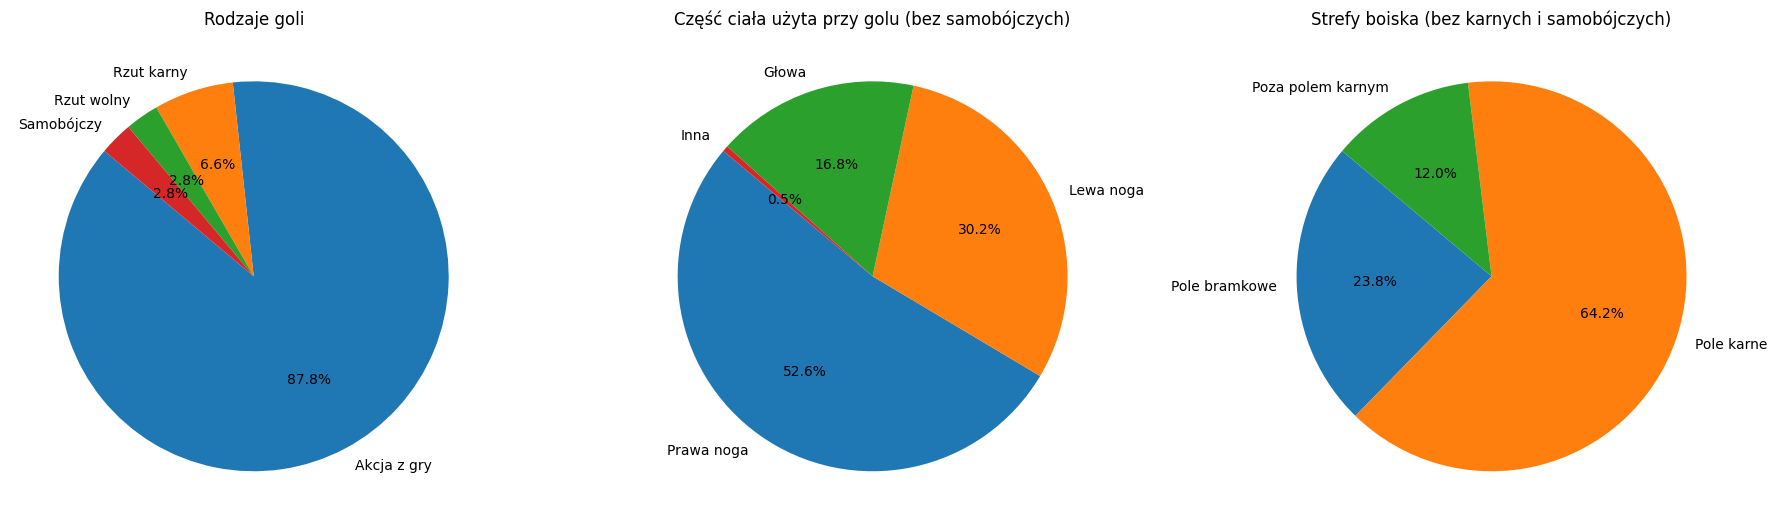

Gol zdobyty z największej odległości: Álvaro Negredo Sánchez, 43.93 m
Średnia odległość: 10.86 meters
Mediana odległości: 9.91 meters


In [14]:
from math import sqrt

# Podział na rodzaj strzału
def classify_goal(row):
    if row['type'] == 'Own Goal For':
        return 'Own Goal'
    else:
        return row.get('shot_type')

goals['goal_type'] = goals.apply(classify_goal, axis=1)
type_labels = {
    'Own Goal' : 'Samobójczy',
    'Open Play' : 'Akcja z gry',
    'Free Kick' : 'Rzut wolny',
    'Penalty' : 'Rzut karny'
}
goal_counts = goals['goal_type'].map(type_labels).value_counts()

#Podział na części ciała
non_own_goals = goals[goals['goal_type'] != 'Own Goal']
body_part_labels = {
    'Left Foot': 'Lewa noga',
    'Right Foot': 'Prawa noga',
    'Head': 'Głowa',
    'Other': 'Inna',
    None: 'Nieznane'
}
body_counts = non_own_goals['shot_body_part'].map(body_part_labels).value_counts()

# Współrzędne strzałów
goals_loc = non_own_goals[non_own_goals['location'].notnull()].copy()
goals_loc = goals_loc[goals_loc['shot_type'] != 'Penalty']
goals_loc['x'] = goals_loc['location'].apply(lambda loc: loc[0])
goals_loc['y'] = goals_loc['location'].apply(lambda loc: loc[1])

# Statsbomb używa współrzędnych 120x80. Wymiary boiska to 105x68m, więc należy zrobić konwersję odległości na metry.
def scaled_distance(x, y):
    x_m = x * (105 / 120)
    y_m = y * (68 / 80)
    return sqrt((105 - x_m)**2 + (34 - y_m)**2)

goals_loc['distance'] = goals_loc.apply(lambda row: scaled_distance(row['x'], row['y']), axis=1)

# Podział na strefy boiska
def classify_zone(x, y):
    if x >= 114 and 26.1 <= y <= 53.9:
        return 'Pole bramkowe'
    elif x >= 102 and 18 <= y <= 62:
        return 'Pole karne'
    return 'Poza polem karnym'

goals_loc['zone'] = goals_loc.apply(lambda row: classify_zone(row['x'], row['y']), axis=1)
zone_counts = goals_loc['zone'].value_counts().reindex(['Pole bramkowe', 'Pole karne', 'Poza polem karnym'], fill_value=0)

# Wykresy
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Rodzaje
axes[0].pie(goal_counts, labels=goal_counts.index, autopct='%1.1f%%', startangle=140)
axes[0].set_title('Rodzaje goli')

# Części ciała
axes[1].pie(body_counts, labels=body_counts.index, autopct='%1.1f%%', startangle=140)
axes[1].set_title('Część ciała użyta przy golu (bez samobójczych)')

# Strefy
axes[2].pie(zone_counts, labels=zone_counts.index, autopct='%1.1f%%', startangle=140)
axes[2].set_title('Strefy boiska (bez karnych i samobójczych)')

plt.tight_layout()
plt.show()

# Statystyki odległości
furthest = goals_loc.loc[goals_loc['distance'].idxmax()]
print(f"Gol zdobyty z największej odległości: {furthest['player']}, {furthest['distance']:.2f} m")
print(f"Średnia odległość: {goals_loc['distance'].mean():.2f} meters")
print(f"Mediana odległości: {goals_loc['distance'].median():.2f} meters")


## Analiza goli – wykresy kołowe

### 1. Rodzaje goli
- Akcja z gry – 87,8%  
- Rzut karny – 6,6%  
- Rzut wolny – 2,8%  
- Gol samobójczy – 2,8%  

Zdecydowana większość goli padła w trakcie gry otwartej.
Rzuty karne, wolne i trafienia samobójcze stanowią niewielki procent wszystkich goli.

### 2. Część ciała użyta przy trafieniu (nie licząc samobójczych)
- Prawa noga – 52,6%  
- Lewa noga – 30,2%  
- Głowa – 16,8%  
- Inna – 0,5%  

Ponad połowa bramek została zdobyta prawą nogą, ale gole główką również mają znaczący udział. Większość strzelców jest prawonożna.

### 3. Strefy boiska z których strzelano (bez karnych i samobójczych)
- Pole karne – 64,2%  
- Pole bramkowe – 23,8%  
- Poza polem karnym – 12,0%  

Bramkę z największej odległości w tym sezonie zdobył Álvaro Negredo Sánchez, oddając strzał z 44m, czyli niemal z połowy boiska.

Najwięcej goli padło z akcji, prawą nogą, w obrębie pola karnego.


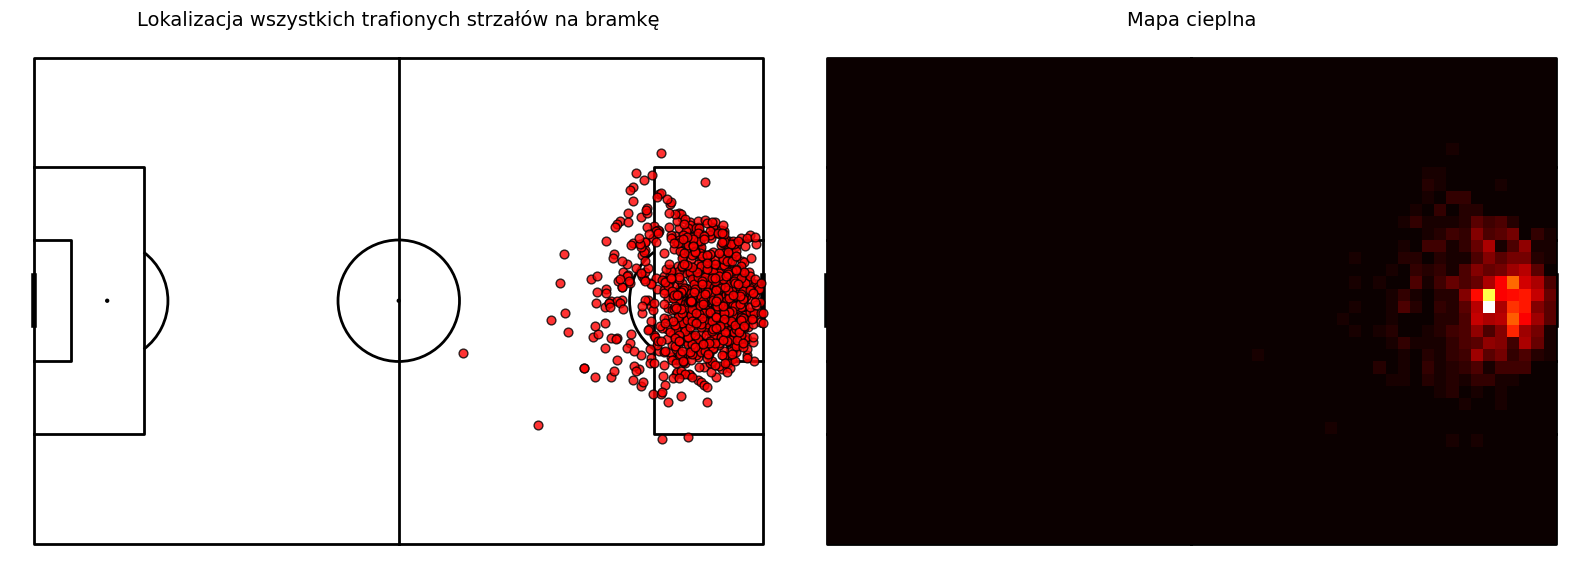

In [ ]:
location_columns = ['location', 'player', 'shot_type']
goals_loc = goals[location_columns].copy()
goals_loc['x'] = goals_loc['location'].apply(lambda loc: loc[0])
goals_loc['y'] = goals_loc['location'].apply(lambda loc: loc[1])

# Boisko z biblioteki mplsoccer
pitch = Pitch(pitch_type='statsbomb', line_color='black', pitch_color='white')
fig, axes = pitch.draw(ncols=2, figsize=(16, 7))

# Wykres punktowy
pitch.scatter(goals_loc['x'], goals_loc['y'], ax=axes[0], color='red', edgecolors='black', s=40, alpha=0.8)
axes[0].set_title('Lokalizacja wszystkich trafionych strzałów na bramkę', color='black', fontsize=14)

# Heatmapa
bin_stat = pitch.bin_statistic(goals_loc['x'], goals_loc['y'], statistic='count', bins=(60, 40))
pitch.heatmap(bin_stat, ax=axes[1], cmap='hot', edgecolors=None)
axes[1].set_title('Mapa cieplna', color='black', fontsize=14)

plt.tight_layout()
plt.show()

Mapa strzałów i mapa ich mapa cieplna natężenia w czytelny sposób ilustrują fakt, że najwięcej goli pada z niewielkiej odległości od bramki.

# Annaliza czasowa

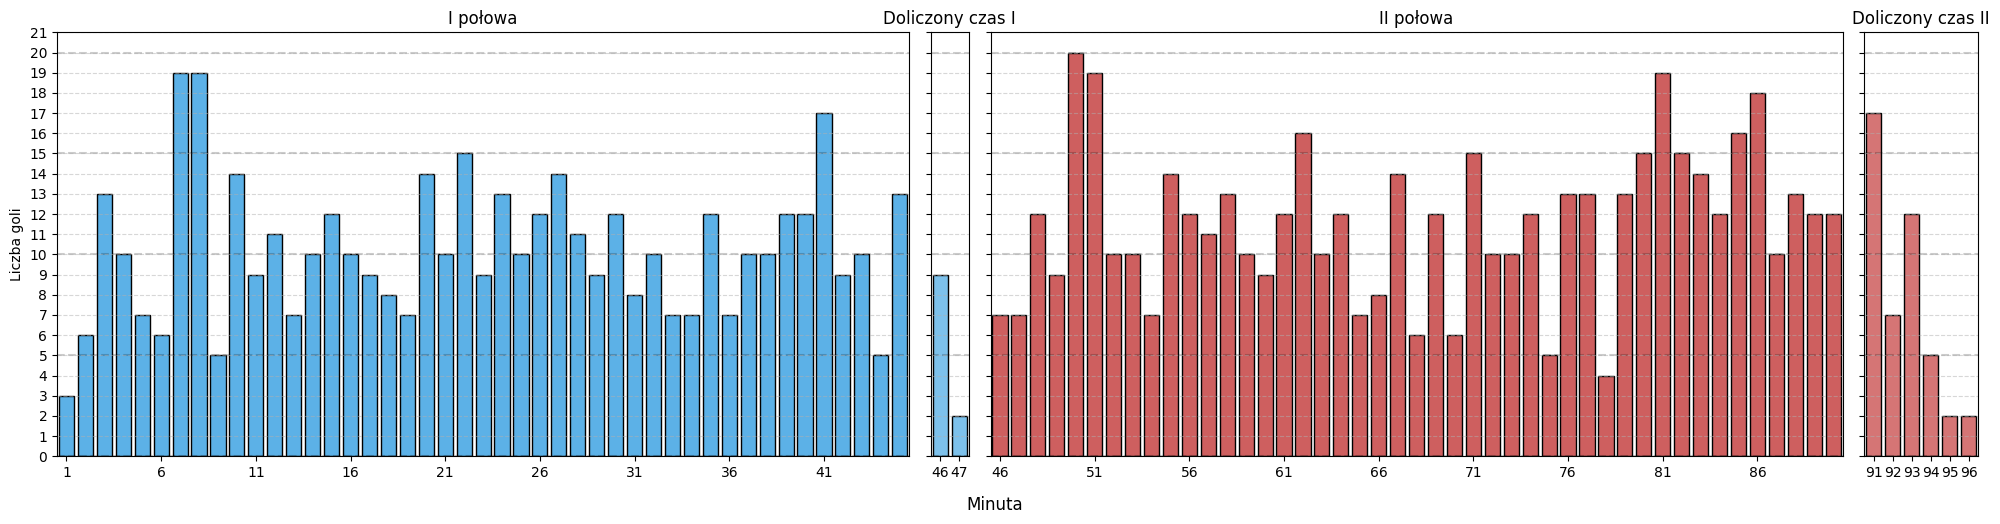

In [16]:
time_cols = [ 'minute', 'period']
goals_time = goals[time_cols].copy()
goals_time['display_minute'] = goals_time['minute'] + 1

first_half = goals_time[(goals['period'] == 1) & (goals_time['minute'] < 45)]
second_half = goals_time[(goals_time['period'] == 2) & (goals_time['minute'] < 90)]
first_half_stoppage = goals_time[(goals['period'] == 1) & (goals_time['minute'] >= 45)]
second_half_stoppage = goals_time[(goals_time['period'] == 2) & (goals_time['minute'] >= 90)]

fig, axes = plt.subplots(
    1, 4, 
    figsize=(20, 5), 
    sharey=True,
    gridspec_kw={'width_ratios': [45, 2, 45, 6]}
)

# I połowa
sns.countplot(
    x='display_minute',
    data=first_half,
    color='#45b6fe',
    edgecolor='black',
    ax=axes[0]
)
axes[0].set_title('I połowa')
axes[0].set_ylabel('Liczba goli')
axes[0].set_xticks(range(0, 45, 5))

# I połowa doliczony czas
sns.countplot(
    x='display_minute',
    data=first_half_stoppage,
    color='#6ac5fe',
    edgecolor='black',
    ax=axes[1]
)
axes[1].set_title('Doliczony czas I')

# II połowa
sns.countplot(
    x='display_minute',
    data=second_half,
    color='#e04c4c',
    edgecolor='black',
    ax=axes[2]
)
axes[2].set_title('II połowa')
axes[2].set_xticks(range(0, 45, 5))

# II połowa doliczony czas
sns.countplot(
    x='display_minute',
    data=second_half_stoppage,
    color='#e56565',
    edgecolor='black',
    ax=axes[3]
)
axes[3].set_title('Doliczony czas II')

for ax in axes:
    ax.grid(axis='y', linestyle='--', alpha=0.5, zorder=0)
    ax.set_yticks(range(0, int(goals_time['display_minute'].value_counts().max()) + 2, 1))
    ax.set_xlabel('')
    y_max = ax.get_ylim()[1]
    for y in range(0, int(y_max)+1):
        if y % 5 == 0:
            ax.axhline(y=y, color='black', zorder=1, alpha=0.2, linestyle='--')

fig.text(0.5, -0.02, 'Minuta', ha='center', va='center', fontsize=12)

plt.tight_layout()
plt.show()




/tmp/ipykernel_874/4172022628.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


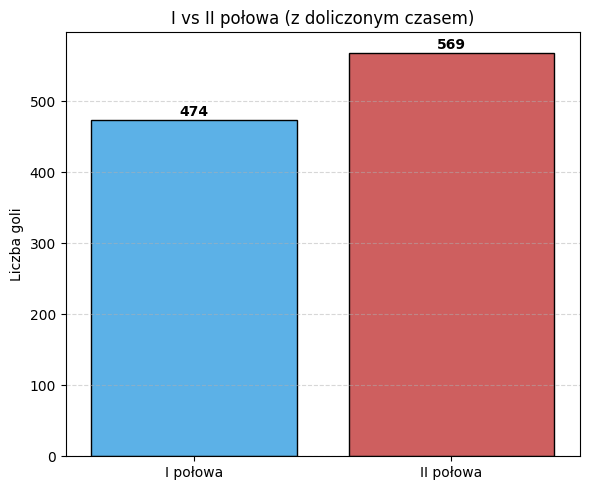

In [17]:
goals_by_half = {
    '1st half': len(first_half) + len(first_half_stoppage),
    '2nd half': len(second_half) + len(second_half_stoppage)
}

df = pd.DataFrame(list(goals_by_half.items()), columns=['half', 'Goals'])

plt.figure(figsize=(6, 5))
sns.barplot(
    data=df,
    x='half',
    y='Goals',
    palette={'1st half': '#45b6fe', '2nd half': '#e04c4c'},
    edgecolor='black'
)

plt.xticks([0, 1], ['I połowa', 'II połowa'])

for i, row in df.iterrows():
    plt.text(i, row['Goals'] + 5, int(row['Goals']), ha='center', fontweight='bold')

plt.title('I vs II połowa (z doliczonym czasem)')
plt.ylabel('Liczba goli')
plt.xlabel('')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Dystrybucja liczby strzelonych goli na minutę meczu jest dość równomierna. Dostrzegalnym trendem jest liczba bramek na połowę - w drugiej strzelono ich o 95 więcej. Ponadto duża liczba goli padała w doliczonym czasie drugiej połowy, podczas gdy w doliczonym czasie pierwszej było ich względnie niewiele. Ostatnie 10 minut drugiej połowy owocowało w większą liczbę goli niż ten sam przedział w pierwszej połowie

Najwięcej goli, 20, strzelono w minucie 50, poza tym w minutach 7, 8 i 51 strzelono ich po 19. Najmniej z w regulaminowym czasie gry padło w minucie 1, bo tylko 3. 2 gole padły w 2 doliczonej minucie pierwszej połowy, a także w 5 i 6 doliczonej minucie drugiej połowy, jednak nie każdy mecz posiada aż 5 czy 6 doliczonych minut.

In [18]:
#Zliczanie wszystkich goli bez samobójczych
non_own_goals = goals[goals['type'] == 'Shot'].copy()
top_scorers = (
    non_own_goals
    .groupby(['player', 'team'])
    .size()
    .reset_index(name='goals')
    .sort_values(by='goals', ascending=False)
)

penalty_goals = (
    non_own_goals[non_own_goals['shot_type'] == 'Penalty']
    .groupby(['player', 'team'])
    .size()
    .reset_index(name='penalties')
)

free_kick_goals = (
    non_own_goals[non_own_goals['shot_type'] == 'Free Kick']
    .groupby(['player', 'team'])
    .size()
    .reset_index(name='free_kicks')
)

top_scorers = top_scorers.merge(penalty_goals, on=['player', 'team'], how='left')
top_scorers = top_scorers.merge(free_kick_goals, on=['player', 'team'], how='left')

top_scorers['penalties'] = top_scorers['penalties'].fillna(0).astype(int)
top_scorers['free_kicks'] = top_scorers['free_kicks'].fillna(0).astype(int)

# Zliczanie goli z akcji
top_scorers['open_play'] = top_scorers['goals'] - top_scorers['penalties'] - top_scorers['free_kicks']

top_scorers = top_scorers.reset_index(drop=True)
top_scorers.index += 1
top_scorers.columns = ['Zawodnik', 'Drużyna', 'Gole', 'Karne', 'Wolne', 'Z akcji']

display(top_scorers.head(20))


,Zawodnik,Drużyna,Gole,Karne,Wolne,Z akcji
1,Luis Alberto Suárez Díaz,Barcelona,40,3,0,37
2,Cristiano Ronaldo dos Santos Aveiro,Real Madrid,35,6,1,28
3,Lionel Andrés Messi Cuccittini,Barcelona,26,3,4,19
4,Karim Benzema,Real Madrid,24,0,0,24
5,Neymar da Silva Santos Junior,Barcelona,24,5,1,18
6,Antoine Griezmann,Atlético Madrid,22,1,2,19
7,Aritz Aduriz Zubeldia,Athletic Club,20,3,0,17
8,Gareth Frank Bale,Real Madrid,19,0,0,19
9,Rubén Castro Martín,Real Betis,19,3,1,15
10,Borja González Tomás,Eibar,18,3,0,15


- Luis Suarez (Barcelona) zdobył najwięcej bramek (40), z czego aż 37 padło z akcji – świadczy to o imponującej skuteczności jego wykończenia. Średnio strzelał więcej niż gola na mecz. Taką statystyką może pochwalić się naprawdę niewielu zawodników w historii (np. Robert Lewandowski 2020/21). 
- Lionel Messi (Barcelona) wyróżnia się dużą liczbą bramek z rzutów wolnych (4) – najwięcej wśród wszystkich zawodników.
- Youssef El-Arabi (Granada) aż 7 z 16 goli zdobył z rzutów karnych, co stanowi niemal połowę. Gdyby nie liczyć jedenastek, nie znalazł by się w najlepszej dwudziestce.

Najwięcej przedstawicieli wśród najlepszych strzelców mają:
- Barcelona – 3 zawodników (Suarez, Messi, Neymar),
- Real Madryt – również 3 (Ronaldo, Benzema, Bale),
Ponownie potwierdza to ofensywną dominację tych klubów.

## Analiza skuteczności

StatsBomb xG (expected goals) to metryka oceniająca prawdopodobieństwo, że dany strzał zakończy się golem, na podstawie czynników takich jak pozycja strzału, rodzaj podania, część ciała użyta do strzału czy obecność obrońców. Jest to zaawansowana statystyka używana do oceny jakości sytuacji strzeleckich i skuteczności zawodników oraz drużyn. Rzeczywista liczba bramek większa od xG oznacza wysoką skuteczność napastników i vice-versa.

In [19]:
# Wyszukaniwanie w bazie danych wszystkich strałów
shot_query = {
    "type": "Shot",
}
shots = pd.DataFrame(list(db.events.find(
    shot_query,{
        '_id' : 0,
        'shot_outcome': 1,
        'player' : 1,
        'team' : 1,
        'shot_statsbomb_xg' : 1,
        'location' : 1
    })))



In [20]:
#Oznaczenie goli
shots['goal'] = shots['shot_outcome'] == 'Goal'

#Drużyny
team_xg_table = shots.groupby('team').agg(
    Shots=('team', 'count'),
    Goals=('goal', 'sum'),
    xG=('shot_statsbomb_xg', 'sum')
).reset_index()

team_xg_table['Performance'] = team_xg_table['Goals'] - team_xg_table['xG']
team_xg_table = team_xg_table.sort_values(by='Goals', ascending=False)

# Optional: Round values for display
team_xg_table[['xG', 'Performance']] = team_xg_table[['xG', 'Performance']].round(2)
team_xg_table = team_xg_table.sort_values(by='Performance', ascending=False)
team_xg_table = team_xg_table.reset_index(drop=True)
team_xg_table.index += 1

#Zawodnicy
player_xg_table = shots.groupby('player').agg(
    Shots=('player', 'count'),
    Goals=('goal', 'sum'),
    xG=('shot_statsbomb_xg', 'sum')
).reset_index()

player_xg_table['Performance'] = player_xg_table['Goals'] - player_xg_table['xG']
player_xg_table = player_xg_table.sort_values(by='Goals', ascending=False)

player_xg_table[['xG', 'Performance']] = player_xg_table[['xG', 'Performance']].round(2)
player_xg_table = player_xg_table.sort_values(by='Performance', ascending=False)
player_xg_table = player_xg_table.reset_index(drop=True)
player_xg_table.index += 1


team_xg_table.columns = ['Drużyna', 'Strzały', 'Gole', 'xG', 'Różnica']
print("Statystyki drużyn")
display(team_xg_table)

player_xg_table.columns = ['Zawodnik', 'Strzały', 'Gole', 'xG', 'Różnica']
print("Najskuteczniejsi zawodnicy")
display(player_xg_table.head(10))
print("Najmniej skuteczni zawodnicy")
display(player_xg_table.tail(10))



Statystyki drużyn


,Drużyna,Strzały,Gole,xG,Różnica
1,Real Madrid,717,108,80.79,27.21
2,Barcelona,604,109,91.43,17.57
3,Atlético Madrid,483,62,52.97,9.03
4,Athletic Club,465,57,50.27,6.73
5,Granada,434,45,39.86,5.14
6,Las Palmas,423,42,36.89,5.11
7,Villarreal,347,42,37.07,4.93
8,Rayo Vallecano,501,52,50.39,1.61
9,Celta Vigo,446,51,50.18,0.82
10,RC Deportivo La Coruña,457,41,41.42,-0.42


Najskuteczniejsi zawodnicy


,Zawodnik,Strzały,Gole,xG,Różnica
1,Luis Alberto Suárez Díaz,139,40,27.65,12.35
2,Gareth Frank Bale,81,19,8.99,10.01
3,Karim Benzema,98,24,17.41,6.59
4,Antoine Griezmann,92,22,15.97,6.03
5,James David Rodríguez Rubio,39,7,2.22,4.78
6,Lionel Andrés Messi Cuccittini,158,26,21.26,4.74
7,Iñaki Williams Arthuer,45,8,3.48,4.52
8,Imanol Agirretxe Arruti,45,13,8.57,4.43
9,Jozabed Sánchez Ruiz,45,9,5.37,3.63
10,Neymar da Silva Santos Junior,123,24,20.47,3.53


Najmniej skuteczni zawodnicy


,Zawodnik,Strzały,Gole,xG,Różnica
440,David Barral Torres,17,0,1.99,-1.99
441,Marco Asensio Willemsen,59,4,6.02,-2.02
442,Diego Roberto Godín Leal,26,1,3.04,-2.04
443,Jorge Franco Alviz,30,1,3.05,-2.05
444,Michael Krohn-Dehli,25,1,3.18,-2.18
445,Daniel Wass,49,2,4.26,-2.26
446,Nordin Amrabat,28,0,2.35,-2.35
447,Rodrigo Moreno Machado,38,2,4.37,-2.37
448,Carlos Alberto Vela Garrido,61,5,8.07,-3.07
449,Álvaro Vázquez García,48,5,9.29,-4.29


Powyższe tabele przedstawiają skumulowane xG na przestrzeni całego sezonu. 1 xG może równie prawdopodobnie oznaczać jedną stuprocentową sytuację ze strzałem z małej odległości na pustą bramkę, jak i 10 trudnych strzałów z wyliczonym prawdopodobieństwem trafienia na poziomie 10%.

- Real Madryt znacznie przewyższa oczekiwania wynikające z xG – strzelił aż o 27 goli więcej niż powinien, co świadczy o niesamowitej skuteczności i jakości jego zawodników. Barcelona przewyższa swoje xG o 17, co również jest bardzo dobrym wynikiem.
- Sevilla natomiast nie prezentuje się dobrze – mimo wysokiego xG (60.89), zdobyła tylko 50 bramek, co sugeruje bardzo słabą skuteczność.

- Wśród zawodników Luis Suárez i Gareth Bale wykazali się największą skutecznością – ich liczba goli znacznie przekroczyła oczekiwania (odpowiednio +12.35 i +10.01).
- Zawodnicy tacy jak Álvaro Vázquez czy Carlos Vela mocno zawiedli – ich różnice xG są wyraźnie ujemne, co może sugerować marnowanie dobrych sytuacji.
- Nordin Amrabat zmarnował wszystkie swoje sytuacje i zakończył sezon bez żadnego gola na koncie.